#Import Google Drive

In [1]:
#Problemi:
#1) non tutte le immagini hanno label
#2) molte immagini di dimensione diversa
#3) trovate alcune immagini con label sbagliato
#4) query non si è capito cosa siano
#5) probabili problemi di ram
#6) Posso avere un immagine in più set (ad esempio, sia good sia junk)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#!unzip "/content/drive/MyDrive/a.zip" -d "/content/drive/MyDrive/Paris/"  > /dev/null

# Carica i file di Ground Truth

In [3]:
import os

good = set();
ok = set();
bad = set();
junk = set();

#groundtruth_dir = "/content/drive/My Drive/OxfordTxt/"
groundtruth_dir = "/content/drive/My Drive/gzp/"


#Itera i file txt nella directory
def leggi_ground_truth_files(directory):
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      rank = filename.split("_")[-1] #la parte finale del nome del file
      if rank == "good.txt":
        leggi_file(f,good)
      elif rank == "ok.txt":
        leggi_file(f,ok)   
      elif rank == "bad.txt":
        leggi_file(f,bad)
      elif rank == "junk.txt":
        leggi_file(f,junk)
      #elif rank == "query.txt":
        #leggi_file(f,query)
  return;


def leggi_file(f, s):
  with open(f) as f:
    lines = f.readlines()
    for line in lines:
      #rimuovo il \n finale e aggiungo .jpg
      line = line[:len(line)-1] + ".jpg"
      s.add(line)
  return;

In [4]:
leggi_ground_truth_files(groundtruth_dir)
print("Numero di good: ", len(good))
print("Numero di ok: ", len(ok))
print("Numero di bad: ", len(bad))
print("Numero di junk: ", len(junk))

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


#Carica DataSet

In [5]:
from PIL import Image
import numpy as np

class_names = ['paris_defense', 'paris_eiffel', 'paris_general', 'paris_invalides', 'paris_louvre', 'paris_moulinrouge',
                'paris_museedorsay', 'paris_notredame', 'paris_pantheon', 'paris_pompidou', 'paris_sacrecoeur', 'paris_triomphe' ]

dataset_dir='/content/drive/My Drive/Paris/'

In [6]:
dataset = []
labels = []
valutazioni = []
formati = set()

#Carica il dataset scartando le foto che non hanno una valutazione o ne hanno
#più di una
def carica_dataset_da_directory(dataset_dir):
  #cicla nelle entry della directory
  for filename in os.listdir(dataset_dir):
    f = os.path.join(dataset_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
      if carica_valutazione(filename) == 0:
        carica_foto(f, dataset)
        carica_label(filename)
  return;

def carica_foto(f, dataset):
  #print(f)
  img = Image.open(f)
  pix = np.array(img)#/255############################################
  formati.add(pix.shape)
  dataset = dataset.append(pix)
  #print(pix)
  return;

def carica_label(filename):
  for i in range(len(class_names)):
    if(filename.startswith(class_names[i])):
      labels.append(i)
      return 
  labels.append(-1)
  return;

def carica_valutazione(filename):
  x = [0,0,0,0] #flag per presenza di filename in good, ok, bad e junk
  if filename in good:
    x[0]=1
  if filename in ok:
    x[1]=1
  if filename in bad:
    x[2]=1
  if filename in junk:
    x[3]=1

  if x[0]+x[1]+x[2]+x[3] >1:
    #print(filename, ": valutazioni discordanti")
    return -1
  if x[0]+x[1]+x[2]+x[3] == 0:
    #print(filename, ": valutazione non disponibile")
    return -2

  if x[0]==1:
    valutazioni.append(0) # good
  elif x[1]==1:
    valutazioni.append(1) # ok
  elif x[2]==1:
    valutazioni.append(2) # bad
  elif x[3]==1:
    valutazioni.append(3) # junk
  return 0;


carica_dataset_da_directory(dataset_dir)

dataset = np.array(dataset)
labels = np.array(labels)
valutazioni = np.array(valutazioni)

<ipython-input-6-1ad7901cc837>:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)


In [7]:
print("Numero immagini del dataset: ", dataset.shape)

flags = np.zeros(len(class_names))
for i in range(labels.shape[0]):
  flags[labels[i]] = flags[labels[i]] + 1
print("Numero di immagini nei vari landmark: ", flags)

a = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],]
for i in range(len(labels)):
  if valutazioni[i] == 1: #ok
    a[labels[i]][0] = a[labels[i]][0] + 1
  if valutazioni[i] == 3: #junk
    a[labels[i]][1] = a[labels[i]][1] + 1
print("Per ogni landark, quanti sono ok e quanti sono junk: ", a)

val_flags = [0,0,0,0]
for i in range(valutazioni.shape[0]):
  val_flags[valutazioni[i]] = val_flags[valutazioni[i]] + 1
print("Immagini good-ok-bad-junk: ", val_flags)

print("formati immagini diversi:", len(formati))

Numero immagini del dataset:  (3389,)
Numero di immagini nei vari landmark:  [232. 129. 683. 266. 249. 345.  90. 205. 319. 147. 280. 444.]
Per ogni landark, quanti sono ok e quanti sono junk:  [[124, 108], [61, 68], [268, 415], [182, 84], [131, 118], [237, 108], [72, 18], [113, 92], [127, 192], [52, 95], [145, 135], [268, 176]]
Immagini good-ok-bad-junk:  [0, 1780, 0, 1609]
formati immagini diversi: 342


#Split dei dati in training, validation, test set

In [8]:
num_samples = len(dataset)

train_len = round(0.8 * num_samples)
val_len   = (num_samples - train_len) // 2
test_len  = (num_samples - train_len - val_len)

x_train = dataset[:train_len]
x_val = dataset[train_len: train_len + val_len]
x_test = dataset[-test_len:]

y_train = labels[:train_len]
y_val = labels[train_len: train_len + val_len]
y_test = labels[-test_len:]

z_train = valutazioni[:train_len]
z_val = valutazioni[train_len: train_len + val_len]
z_test = valutazioni[-test_len:]

#Data Augmentation

In [10]:
#eventuali trasformazioni

Training set examples


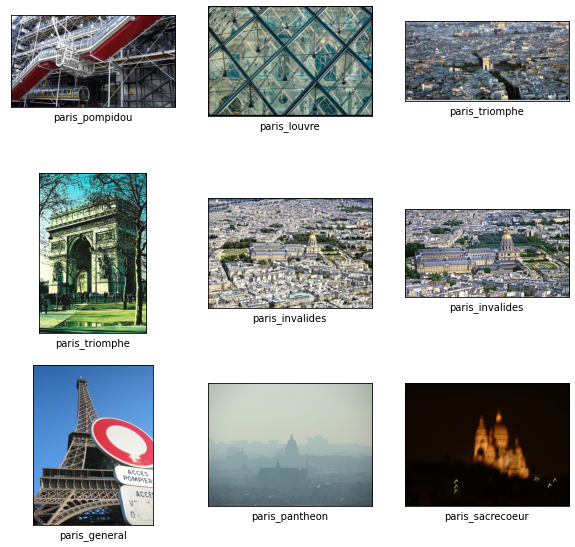

In [9]:
import matplotlib.pyplot as plt

#Stampa esempi
print("Training set examples")
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i]/255, cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.show()

#Creazione di Coppie

In [11]:
import random
#TODO: modificare make pair in modo da usare i dati delle valutazioni
def make_pairs(x, y, z):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.
        z: List containing valutazioni (good, ok, bad, junk)

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = len(class_names)
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    #digit_indices = [[lista indici landmark 1], [lista indici landmark 2], ...]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        if z[idx1] == 3:
          continue #salto i junk, non ha senso considerarli come buoni
        x1 = x[idx1]
        label1 = y[idx1]

        k = 3 #(k = junk) Non voglio nel matching example un junk
        while k==3:
          idx2 = random.choice(digit_indices[label1])
          k = z[idx2]
        
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        # Qua mi va bene anche se mi capita una coppia good-junk, lascio i junk
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [12]:
# make train, validation and test pairs
pairs_train, labels_train = make_pairs(x_train, y_train, z_train)
pairs_val, labels_val = make_pairs(x_val, y_val, z_val)
pairs_test, labels_test = make_pairs(x_test, y_test, z_test)

print(len(pairs_train), len(labels_train))
print(len(pairs_val), len(labels_val))
print(len(pairs_test), len(labels_test))

3028 3028
298 298
234 234


<ipython-input-11-1982d78cac3d>:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pairs), np.array(labels).astype("float32")


#Creazione Triplet

In [13]:
def make_triplet(x, y, z):
  pairs = []
  labels = []

  num_classes = len(class_names)
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  for idx1 in range(len(x)):
    # add a matching example
    if z[idx1] == 3:
      continue #salto i junk, non ha senso considerarli come buoni
    x1 = x[idx1]
    label1 = y[idx1]

    k = 3 #(k = junk) Non voglio nel matching example un junk
    while k==3:
      idx2 = random.choice(digit_indices[label1])
      k = z[idx2]
    
    x2 = x[idx2]

    # add a non-matching example
    # Qua mi va bene anche se mi capita una coppia good-junk, lascio i junk
    label2 = random.randint(0, num_classes - 1)
    while label2 == label1:
        label2 = random.randint(0, num_classes - 1)

    idx2 = random.choice(digit_indices[label2])
    x3 = x[idx2]

    pairs += [[x1, x2, x3]]
  return np.array(pairs)

In [14]:
# make train, validation and test triplet
triplet_train = make_triplet(x_train, y_train, z_train)
triplet_val = make_triplet(x_val, y_val, z_val)
triplet_test = make_triplet(x_test, y_test, z_test)

print(len(triplet_train))
print(len(triplet_val))
print(len(triplet_test))

1514
149
117


<ipython-input-13-5ccd255aee05>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pairs)


#Definizione del modello (Binario)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

